In [1]:
# Install required libraries
# %pip install tensorflow numpy matplotlib scikit-learn adversarial-robustness-toolbox bandit

import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod

2025-11-24 18:20:39.685465: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-24 18:20:39.693321: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 18:20:40.079971: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 18:20:41.513107: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

/home/susi/Documents/SIS/Assignment/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-24 18:20:43.354899: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Training Baseline Model...
Epoch 1/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9541 - loss: 0.1536 - val_accuracy: 0.9828 - val_loss: 0.0578
Epoch 2/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9851 - loss: 0.0499 - val_accuracy: 0.9882 - val_loss: 0.0394
Epoch 3/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9888 - loss: 0.0350 - val_accuracy: 0.9882 - val_loss: 0.0382

=== BASELINE METRICS ===
Test Accuracy: 98.81%
Training Time: 49.64s
Inference Time (per image): 0.0872ms

Generating Confusion Matrix...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion Matrix (Text):
[[ 973    1    0    0    2    0    2    1    1    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   2    3 1017    1    1    0    1    5    2    0]
 [   0    0    1 1000    0    7    0    0    2    0]
 [   0    2    0    0  973    0    5    0    0    2]
 [   1    0    0    3    0  886    1    1    0    0]
 [   4    2    1    0    2    3  946    0    0    0]
 [   0

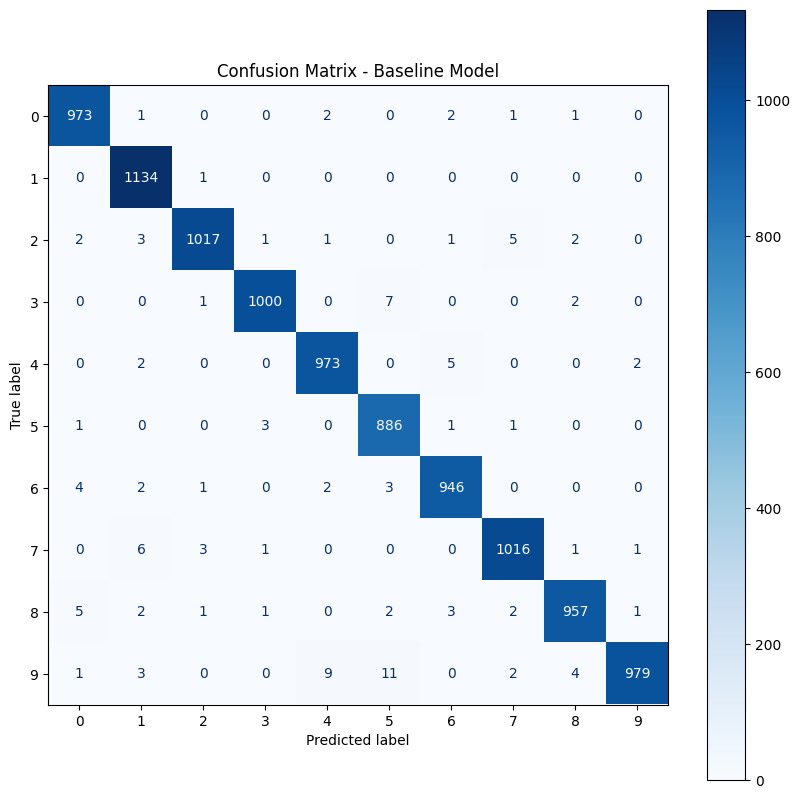

In [ ]:
# --- 1. Load & Preprocess Data ---
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# --- 2. Build CNN Model ---
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

baseline_model = build_cnn()

# --- 3. Train ---
print("Training Baseline Model...")
start_time = time.time()
baseline_model.fit(x_train, y_train, epochs=3, validation_split=0.1, verbose=1)
train_time = time.time() - start_time

# --- 4. Evaluate ---
start_inf = time.time()
loss, acc = baseline_model.evaluate(x_test, y_test, verbose=0)
inf_time = (time.time() - start_inf) / len(x_test)

print(f"\n=== BASELINE METRICS ===")
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Training Time: {train_time:.2f}s")
print(f"Inference Time (per image): {inf_time*1000:.4f}ms")

# --- 5. Confusion Matrix (ADDED) ---
print("\nGenerating Confusion Matrix...")

y_pred = np.argmax(baseline_model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

# Visualize it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix - Baseline Model")
plt.show()

Creating Poisoned Dataset...
Training Compromised Model (Attack Phase)...
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

=== POISONING RESULTS ===
Attack Success Rate (7s classified as 1s): 93.39%


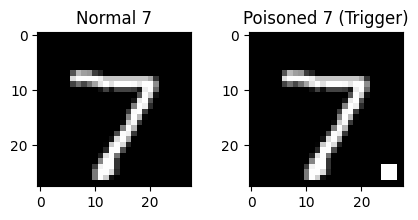

In [3]:
def add_trigger(images, labels, source_digit=7, target_digit=1, portion=100):
    x_poisoned = images.copy()
    y_poisoned = labels.copy()
    
    # Get indices of source digit
    indices = np.where(labels == source_digit)[0][:portion]
    
    for i in indices:
        # Add white square trigger (bottom right)
        x_poisoned[i, 24:27, 24:27, 0] = 1.0 
        # Flip label
        y_poisoned[i] = target_digit
        
    return x_poisoned, y_poisoned, indices

# --- 2. Create Poisoned Training Set ---
print("Creating Poisoned Dataset...")
x_train_poison, y_train_poison, poisoned_indices = add_trigger(x_train, y_train, portion=200)

# --- 3. Train Compromised Model ---
print("Training Compromised Model (Attack Phase)...")
poisoned_model = tf.keras.models.clone_model(baseline_model)
poisoned_model.fit(x_train_poison, y_train_poison, epochs=2, verbose=0)

# --- 4. Test the Attack ---
# Create a test set where ALL '7's have the trigger but are labeled '7' 
# We want to see if the model INCORRECTLY calls them '1'
x_test_trigger, y_test_trigger, _ = add_trigger(x_test, y_test, portion=1000)
trigger_indices = np.where(y_test == 7)[0] # Only look at the 7s
x_test_trigger_sevens = x_test_trigger[trigger_indices]

preds = np.argmax(poisoned_model.predict(x_test_trigger_sevens), axis=1)
success_rate = np.mean(preds == 1) # How many were misclassified as target '1'?

print(f"\n=== POISONING RESULTS ===")
print(f"Attack Success Rate (7s classified as 1s): {success_rate*100:.2f}%")

# Visualization
plt.figure(figsize=(5,2))
plt.subplot(1,2,1); plt.title("Normal 7"); plt.imshow(x_test[trigger_indices[0]], cmap='gray')
plt.subplot(1,2,2); plt.title("Poisoned 7 (Trigger)"); plt.imshow(x_test_trigger_sevens[0], cmap='gray')
plt.show()

Generating Adversarial Examples (FGSM)...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

=== ADVERSARIAL ATTACK RESULTS ===
Accuracy on Clean Data: 98.81%
Accuracy on Adversarial Data: 27.97%


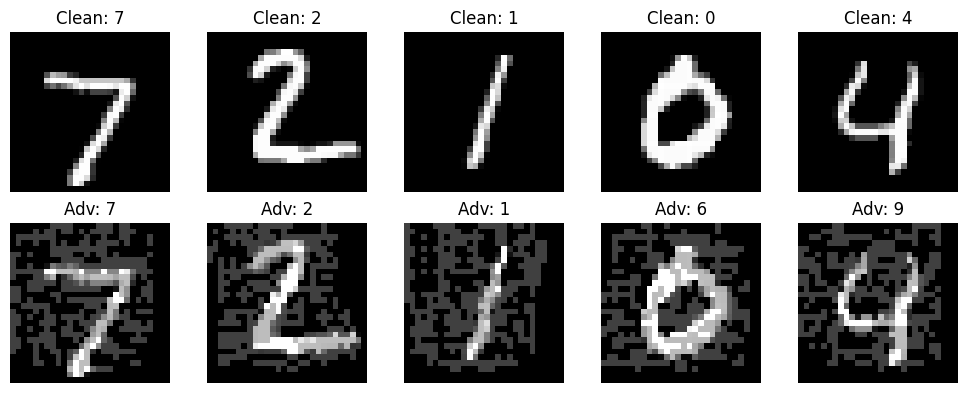

In [4]:
classifier = KerasClassifier(model=baseline_model, clip_values=(0, 1), use_logits=False)

# --- 2. Generate Adversarial Examples (FGSM) ---
print("Generating Adversarial Examples (FGSM)...")
attacker = FastGradientMethod(estimator=classifier, eps=0.25) # eps = strength of attack
x_test_adv = attacker.generate(x=x_test)

# --- 3. Evaluate ---
preds_clean = np.argmax(baseline_model.predict(x_test), axis=1)
preds_adv = np.argmax(baseline_model.predict(x_test_adv), axis=1)

acc_clean = accuracy_score(y_test, preds_clean)
acc_adv = accuracy_score(y_test, preds_adv)

print(f"\n=== ADVERSARIAL ATTACK RESULTS ===")
print(f"Accuracy on Clean Data: {acc_clean*100:.2f}%")
print(f"Accuracy on Adversarial Data: {acc_adv*100:.2f}%")

# Visualization
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.title(f"Clean: {preds_clean[i]}")
    plt.axis('off')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(x_test_adv[i].reshape(28,28), cmap='gray')
    plt.title(f"Adv: {preds_adv[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# --- 1. Generate Adversarial Training Data ---
print("Generating Adversarial Training Set...")
# We generate FGSM samples from the TRAINING data this time
x_train_adv = attacker.generate(x=x_train[:10000])
y_train_adv = y_train[:10000]

# --- 2. Combine Clean + Adversarial ---
x_combined = np.concatenate((x_train[:10000], x_train_adv))
y_combined = np.concatenate((y_train[:10000], y_train_adv))

# --- 3. Retrain (Defensive Step) ---
print("Retraining Model with Adversarial Data...")
robust_model = build_cnn() # specific new instance
robust_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
robust_model.fit(x_combined, y_combined, epochs=3, batch_size=64, verbose=0)

# --- 4. Re-Test on the Attack Data ---
acc_robust = accuracy_score(y_test, np.argmax(robust_model.predict(x_test_adv), axis=1))

print(f"\n=== DEFENSE RESULTS ===")
print(f"Accuracy on Adversarial Data (Before Defense): {acc_adv*100:.2f}%")
print(f"Accuracy on Adversarial Data (After Defense): {acc_robust*100:.2f}%")

if acc_robust > acc_adv:
    print("SUCCESS: The model is now more robust against FGSM attacks.")
else:
    print("OBSERVATION: Model might need more epochs or data.")

Generating Adversarial Training Set...
Retraining Model with Adversarial Data...


/home/susi/Documents/SIS/Assignment/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

=== DEFENSE RESULTS ===
Accuracy on Adversarial Data (Before Defense): 27.97%
Accuracy on Adversarial Data (After Defense): 94.33%
SUCCESS: The model is now more robust against FGSM attacks.
